In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import casadi as ca
from pytope import Polytope
from matplotlib.animation import FuncAnimation
from scipy.spatial import ConvexHull
from scipy.stats import multivariate_normal
from tqdm import tqdm

In [277]:
simulation_time = 300
x_low = 0
x_up = 100
y_low = 0
y_up = 5

road_vertices = np.array([
    [x_low, y_low],
    [x_low, y_up],
    [x_up, y_up],
    [x_up, y_low],
])

Drive_Area = Polytope(road_vertices)
A_road = Drive_Area.A
b_road = Drive_Area.b

In [278]:
class SV_controller(): #without risk
    def __init__(self, Param):

        self.SV_Acc = Param["init_acc"]
        self.N = Param["N"] 
        self.T = Param["T"] 
        self.radius = Param["radius"]
        self.num_vertices = Param["num_vertices"]
        self.l_f = Param["l_f"] 
        self.l_r = Param["l_r"] 
        self.l_veh = Param["l_veh"] 
        self.w_veh = Param["w_veh"] 
        self.DEV = Param["DEV"]
        self.Q1 = Param["Q1"]
        self.Q2 = Param["Q2"]
        self.Q3 = Param["Q3"]
        self.Q4 = Param["Q4"]
        self.Q5 = Param["Q5"]
        self.Q6 = Param["Q6"]
        self.Q7 = Param["Q7"]
        self.d_min = Param["d_min"]
        self.A_road = Param["A_road"]
        self.b_road = Param["b_road"]
        self.v_low = Param["v_low"]
        self.v_up = Param["v_up"]
        self.acc_low = Param["acc_low"]
        self.acc_up = Param["acc_up"]
        self.delta_low = Param["delta_low"]
        self.delta_up = Param["delta_up"]
        self.RefSpeed = Param["RefSpeed"]
        self.RefPos = Param["RefPos"]
        
        self.U_SV_Poly = self.Generate_Polytope(self.radius,self.num_vertices)
        self.H = self.U_SV_Poly.A 
        self.h = self.U_SV_Poly.b 
        self.nv = np.size(self.H, 0)
        self.nu = np.size(self.H, 1)
        for i in range(self.nv):
            self.H[i,:] /= self.h[i]
        self.h = np.ones_like(self.h)
        self.N_Sam = self.SV_Acc.shape[1]

        self.LP = self.OR_LP()
        self.theta_pre,self.y_pre,self.rho_pre = self.LP(np.array([[0],[0]]),np.zeros((self.nu,1)),0.1*np.ones((self.nv,1)))
        self.MPC = self.MPCFormulation()


    def Return(self,SV_Acc_new, SV_Pos_new, SV_Vel_new, tmp , current_x_EV):

        RefSpeed = self.RefSpeed
        RefPos = self.RefPos
        G, g, Occupancy_SV = self.ReachableSet(SV_Acc_new, SV_Pos_new, SV_Vel_new)
        RefXPos = RefPos[0]
        RefYPos = RefPos[1]
        RefPhi  = RefPos[2]
        Trajectory_k, Control_k, J_k, s_k = self.MPC(0.5*G, 0.5*g, current_x_EV, RefSpeed, RefXPos, RefYPos, RefPhi)
        Trajectory_k = Trajectory_k.full( )
        Control_k = Control_k.full( )

        return Control_k[:, 0], Trajectory_k, J_k.full( ), Occupancy_SV, tmp


    def ReachableSet(self,SV_Acc_new, SV_Pos_new, SV_Vel_new):

        self.U_Hat_Poly = self.OR(SV_Acc_new)

        A_SV = np.array([[1, self.T, 0, 0], [0, 1, 0, 0], [0, 0, 1, self.T], [0, 0, 0, 1]])
        B_SV = np.array([[0.5*self.T**2, 0], [self.T, 0], [0, 0.5*self.T**2], [0, self.T]])
        BU = B_SV*self.U_Hat_Poly
        Reachable_Set = list()
        Occupancy_SV = list()
        x_t = np.array([SV_Pos_new[0], SV_Vel_new[0], SV_Pos_new[1], SV_Vel_new[1]])
        Reachable_Set.append(x_t)
        G = np.zeros((4, 2*self.N)) 
        g = np.zeros((4, self.N))

        for t in range(1,self.N+1):
            if t == 1:
                reachable_set_t = (A_SV@Reachable_Set[t - 1] + BU) 
            else:
                reachable_set_t = (A_SV*Reachable_Set[t - 1] + BU) 
            
            vertex = reachable_set_t.V
            vertex_xy = np.delete(vertex, [1, 3], axis = 1)
            occupancy_SV_t = Polytope(vertex_xy) 
            occupancy_SV_t.minimize_V_rep( )
            temp_poly   = occupancy_SV_t
            G[:, 2*t-2:2*t] = temp_poly.A
            g[:, t-1]       = temp_poly.b.reshape(4, )

            Occupancy_SV.append(temp_poly)
            Reachable_Set.append(reachable_set_t)

        return G, g, Occupancy_SV
    

    def MPCFormulation(self):

        d_min = self.d_min          #minimum distance
        N = self.N                  #prediction length
        DEV = self.DEV              #dimension
        T = self.T                  #sampling interval
        Q1 = self.Q1                #weighting matrix steering wheel angle
        Q2 = self.Q2                #weighting matrix longitudinal jerk
        Q3 = self.Q3                #weighting matrix long. velocity error
        Q4 = self.Q4                #weighting matrix long. pos. error
        Q5 = self.Q5                #weighting matrix lat. pos. error
        Q6 = self.Q6                #weighting matrix heading. error
        Q7 = self.Q7                #weighting matrix slack variable
        A_road = self.A_road        #driving area.A
        b_road = self.b_road        #driving area.B
        v_up = self.v_up 
        v_low = self.v_low
        acc_low = self.acc_low 
        acc_up = self.acc_up 
        delta_low = self.delta_low 
        delta_up = self.delta_up

        opti = ca.Opti( )
        X = opti.variable(DEV, N + 1)
        U = opti.variable(2, N)
        delta = U[0, :]
        eta   = U[1, :]
        lam = opti.variable(4, N)
        s   = opti.variable(N, 1)

        G = opti.parameter(4, 2*N)
        g = opti.parameter(4, N)
        Initial = opti.parameter(DEV, 1)
        v_ref = opti.parameter( )
        x_ref = opti.parameter( )
        y_ref = opti.parameter( )
        phi_ref = opti.parameter( )

        opti.subject_to(X[:, 0] == Initial)
        for k in range(N):
            k1 = self.vehicle_model(X[:, k], delta[k], eta[k])
            k2 = self.vehicle_model(X[:, k] + T/2*k1, delta[k], eta[k])
            k3 = self.vehicle_model(X[:, k] + T/2*k2, delta[k], eta[k])
            k4 = self.vehicle_model(X[:, k] + T*k3, delta[k], eta[k])
            x_next = X[:, k] + T/6 * (k1 + 2*k2 + 2*k3 + k4)
            opti.subject_to(X[:, k + 1] == x_next) 
        x = X[0, 1::]
        y = X[1, 1::]
        phi = X[2, 1::]
        v = X[3, 1::]
        a = X[4, 1::]
        phi_error = phi[-1] - phi_ref
        v_error = v[-1] - v_ref # longitudinal speed error
        x_error = x[-1] - x_ref # longitudinal position error
        y_error = y[-1] - y_ref # lateral position error

        for k in range(N):
            p_point = X[0:2, k + 1]
            
            G_point = G[:, 2*k:2*k + 2]
            g_point = g[:, k]
            temp = G_point.T@lam[:, k]
            scale_factor = 1
            opti.subject_to((G_point@ca.reshape(p_point,2,1) - g_point).T@lam[:, k] >= scale_factor*d_min - s[k])
            opti.subject_to(temp[0]**2 + temp[1]**2 == 1)
            opti.subject_to(0 <= lam[:, k])
            opti.subject_to(A_road@ca.reshape(p_point,2,1) <= b_road)

        # opti.subject_to(opti.bounded(0, s, d_min))
        opti.subject_to(0 <= s)
        opti.subject_to(opti.bounded(v_low, v, v_up))
        opti.subject_to(opti.bounded(acc_low, a, acc_up))
        opti.subject_to(opti.bounded(delta_low, delta, delta_up))
        
        J = delta@Q1@delta.T + eta@Q2@eta.T + Q3*v_error@v_error.T + Q4*x_error@x_error.T + Q5*y_error@y_error.T + Q6*phi_error@phi_error.T + Q7*s.T@s
        opti.minimize(J)
        
        opts = {"ipopt.print_level": 0, "print_time": False} #"ipopt.linear_solver": "ma57",
        opti.solver('ipopt', opts)

        return opti.to_function('g', [G, g, Initial, v_ref, x_ref, y_ref, phi_ref], [X, U, J, s])
    

    def  vehicle_model(self, w, delta, eta):

        l_f = self.l_f
        l_r = self.l_r
        
        beta = np.arctan(l_r/(l_f + l_r)*np.tan(delta))
        x_dot   = w[3]*np.cos(w[2] + beta) 
        y_dot   = w[3]*np.sin(w[2] + beta)
        phi_dot = w[3]/(l_r)*np.sin(beta)
        v_dot = w[4]
        a_dot = eta
        
        return ca.vertcat(x_dot, y_dot, phi_dot, v_dot, a_dot)
    

    def Generate_Polytope(self, radius, num_vertices):

        if num_vertices != 4:
            angles = np.linspace(0, 2 * np.pi, num_vertices, endpoint=False)
            x_coords = radius * np.cos(angles)
            y_coords = radius * np.sin(angles)

            vertices = np.column_stack((x_coords, y_coords))
            U_SV_Poly = Polytope(vertices)

            return U_SV_Poly
        else:
            low_bound_control  = (-radius, -radius)
            up_bound_control   = (radius,   radius)
            U_SV_Poly = Polytope(lb = low_bound_control, ub = up_bound_control)
            return U_SV_Poly  


    def OR_LP(self):

        H = self.H
        nv = self.nv
        nu = self.nu

        opti = ca.Opti()

        rho = opti.variable()
        theta = opti.variable(nv,1)
        y = opti.variable(nu,1)

        samples = opti.parameter(nu, 1)
        y_pre = opti.parameter(nu,1)
        theta_pre = opti.parameter(nv,1)

        opti.minimize(rho + np.ones((1, nv))@theta)

        opti.subject_to(H @ samples-H @ y <= theta)
        opti.subject_to(H @ y_pre + theta_pre <= H @ y + theta)
        opti.subject_to(H @ y <= (1 - rho)@np.ones((nv,1)))
        opti.subject_to(opti.bounded(0, theta, 1))
        opti.subject_to(opti.bounded(0, rho, 1))
        opti.subject_to(theta <= rho@np.ones((nv,1)))

        opts = {"ipopt.print_level": 0, "print_time": False}
        opti.solver('ipopt', opts)

        return opti.to_function('f', [samples, y_pre, theta_pre], [theta, y, rho])    
    

    def OR(self,SV_Acc_new):

        self.theta_pre,self.y_pre,self.rho_pre = self.LP(SV_Acc_new,self.y_pre,self.theta_pre)
        U_Hat_Poly = Polytope(self.H, self.theta_pre)+self.y_pre

        return U_Hat_Poly
    

    def Plot_Polytope(self):

        plt.figure()
        self.U_SV_Poly.plot(color = 'b', alpha = 0.3)
        self.U_Hat_Poly.plot(color = 'r', alpha = 0.3)

        plt.scatter(self.SV_Acc[0,:],self.SV_Acc[1,:],marker='x',color = 'black')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("Polytope Visualization")
        plt.xlabel("Long Acc")
        plt.ylabel("Lat Acc")
        plt.grid(True)
        plt.show()


    def vehicle_model(self, w, delta, eta):
        
        l_f = self.l_f
        l_r = self.l_r
        
        beta = np.arctan(l_r/(l_f + l_r)*np.tan(delta))
        x_dot   = w[3]*np.cos(w[2] + beta) 
        y_dot   = w[3]*np.sin(w[2] + beta)
        phi_dot = w[3]/(l_r)*np.sin(beta)
        v_dot = w[4]
        a_dot = eta
        
        return ca.vertcat(x_dot, y_dot, phi_dot, v_dot, a_dot)

In [279]:
class EV_controller(): #with risk
    def __init__(self, Param):
        self.SV_Acc = Param["init_acc"]
        self.N = Param["N"] 
        self.T = Param["T"] 
        self.radius = Param["radius"]
        self.num_vertices = Param["num_vertices"]
        self.l_f = Param["l_f"] 
        self.l_r = Param["l_r"] 
        self.l_veh = Param["l_veh"] 
        self.w_veh = Param["w_veh"] 
        self.DEV = Param["DEV"]
        self.Q1 = Param["Q1"]
        self.Q2 = Param["Q2"]
        self.Q3 = Param["Q3"]
        self.Q4 = Param["Q4"]
        self.Q5 = Param["Q5"]
        self.Q6 = Param["Q6"]
        self.Q7 = Param["Q7"]
        self.d_min = Param["d_min"]
        self.A_road = Param["A_road"]
        self.b_road = Param["b_road"]
        self.v_low = Param["v_low"]
        self.v_up = Param["v_up"]
        self.acc_low = Param["acc_low"]
        self.acc_up = Param["acc_up"]
        self.delta_low = Param["delta_low"]
        self.delta_up = Param["delta_up"]
        self.RefSpeed = Param["RefSpeed"]
        self.RefPos = Param["RefPos"]

        self.RiskRefLine = Param["RiskRefLine"]
        self.RiskRefAngle = Param["RiskRefAngle"]
        
        self.U_SV_Poly = self.Generate_Polytope(self.radius,self.num_vertices)
        self.H = self.U_SV_Poly.A 
        self.h = self.U_SV_Poly.b 
        self.nv = np.size(self.H, 0)
        self.nu = np.size(self.H, 1)
        for i in range(self.nv):
            self.H[i,:] /= self.h[i]
        self.h = np.ones_like(self.h)
        self.N_Sam = self.SV_Acc.shape[1]

        self.LP = self.OR_LP()
        self.theta_pre,self.y_pre,self.rho_pre = self.LP(np.array([[0],[0]]),np.zeros((self.nu,1)),0.1*np.ones((self.nv,1)))
        self.MPC = self.MPCFormulation()

    def risk_estimation(self,y_pos,head):
        y_mean = self.RiskRefLine
        head_mean = self.RiskRefAngle
        y_expand = 2.5
        head_expand = np.pi/4
        y_sigma = y_expand/2
        head_sigma = head_expand/2
        correlation = 0
        mean = [y_mean, head_mean]
        cov = [[y_sigma**2, correlation],
        [correlation, head_sigma**2]]
        rv = multivariate_normal(mean, cov)
        pdf_value = rv.pdf([y_pos,head])
        max_pdf_value = 1 / (2 * np.pi * y_sigma * head_sigma)
        risk = pdf_value/max_pdf_value
        if risk > 1:
            risk = 1
        if risk < 0.05:
            risk = 0.05
        
        return risk


    def Return(self,SV_Acc_new, SV_Pos_new, SV_Vel_new, SV_heading, current_x_EV):

        RefSpeed = self.RefSpeed
        RefPos = self.RefPos
        risk = self.risk_estimation(SV_Pos_new[1,0],SV_heading)
        G, g, Occupancy_SV = self.ReachableSet(SV_Acc_new, SV_Pos_new, SV_Vel_new, risk)
        RefXPos = RefPos[0]
        RefYPos = RefPos[1]
        RefPhi  = RefPos[2]
        Trajectory_k, Control_k, J_k, s_k = self.MPC(G, g, current_x_EV, RefSpeed, RefXPos, RefYPos, RefPhi)
        Trajectory_k = Trajectory_k.full( )
        Control_k = Control_k.full( )

        return Control_k[:, 0], Trajectory_k, J_k.full( ), Occupancy_SV, risk


    def ReachableSet(self,SV_Acc_new, SV_Pos_new, SV_Vel_new, risk):

        self.U_Hat_Poly = self.OR(SV_Acc_new)

        A_SV = np.array([[1, self.T, 0, 0], [0, 1, 0, 0], [0, 0, 1, self.T], [0, 0, 0, 1]])
        B_SV = np.array([[0.5*self.T**2, 0], [self.T, 0], [0, 0.5*self.T**2], [0, self.T]])
        BU = B_SV*self.U_Hat_Poly
        Reachable_Set = list()
        Occupancy_SV = list()

        x_t = np.array([SV_Pos_new[0], SV_Vel_new[0], SV_Pos_new[1], SV_Vel_new[1]])
        Reachable_Set.append(x_t)
        G = np.zeros((4, 2*self.N)) 
        g = np.zeros((4, self.N))

        for t in range(1,self.N+1):
            if t == 1:
                reachable_set_t = (A_SV@Reachable_Set[t - 1] + BU) 
            else:
                reachable_set_t = (A_SV*Reachable_Set[t - 1] + BU) 
            
            vertex = reachable_set_t.V
            vertex_xy = np.delete(vertex, [1, 3], axis = 1)
            
            # Calculate center of the polytope
            center = np.mean(vertex_xy, axis=0)
            
            # Scale vertices around the center
            scaled_vertex = center + risk * (vertex_xy - center)
            
            occupancy_SV_t = Polytope(scaled_vertex) 
            occupancy_SV_t.minimize_V_rep()
            temp_poly = occupancy_SV_t
            G[:, 2*t-2:2*t] = temp_poly.A
            g[:, t-1] = temp_poly.b.reshape(4, )

            Occupancy_SV.append(temp_poly)
            Reachable_Set.append(reachable_set_t)

        return G, g, Occupancy_SV
    

    def MPCFormulation(self):

        d_min = self.d_min          #minimum distance
        N = self.N                  #prediction length
        DEV = self.DEV              #dimension
        T = self.T                  #sampling interval
        Q1 = self.Q1                #weighting matrix steering wheel angle
        Q2 = self.Q2                #weighting matrix longitudinal jerk
        Q3 = self.Q3                #weighting matrix long. velocity error
        Q4 = self.Q4                #weighting matrix long. pos. error
        Q5 = self.Q5                #weighting matrix lat. pos. error
        Q6 = self.Q6                #weighting matrix heading. error
        Q7 = self.Q7                #weighting matrix slack variable
        A_road = self.A_road        #driving area.A
        b_road = self.b_road        #driving area.B
        v_up = self.v_up 
        v_low = self.v_low
        acc_low = self.acc_low 
        acc_up = self.acc_up 
        delta_low = self.delta_low 
        delta_up = self.delta_up

        opti = ca.Opti( )
        X = opti.variable(DEV, N + 1)
        U = opti.variable(2, N)
        delta = U[0, :]
        eta   = U[1, :]
        lam = opti.variable(4, N)
        s   = opti.variable(N, 1)

        G = opti.parameter(4, 2*N)
        g = opti.parameter(4, N)
        Initial = opti.parameter(DEV, 1)
        v_ref = opti.parameter( )
        x_ref = opti.parameter( )
        y_ref = opti.parameter( )
        phi_ref = opti.parameter( )

        opti.subject_to(X[:, 0] == Initial)
        for k in range(N):
            k1 = self.vehicle_model(X[:, k], delta[k], eta[k])
            k2 = self.vehicle_model(X[:, k] + T/2*k1, delta[k], eta[k])
            k3 = self.vehicle_model(X[:, k] + T/2*k2, delta[k], eta[k])
            k4 = self.vehicle_model(X[:, k] + T*k3, delta[k], eta[k])
            x_next = X[:, k] + T/6 * (k1 + 2*k2 + 2*k3 + k4)
            opti.subject_to(X[:, k + 1] == x_next) 
        x = X[0, 1::]
        y = X[1, 1::]
        phi = X[2, 1::]
        v = X[3, 1::]
        a = X[4, 1::]
        phi_error = phi[-1] - phi_ref
        v_error = v[-1] - v_ref # longitudinal speed error
        x_error = x[-1] - x_ref # longitudinal position error
        y_error = y[-1] - y_ref # lateral position error

        for k in range(N):
            p_point = X[0:2, k + 1]
            
            G_point = G[:, 2*k:2*k + 2]
            g_point = g[:, k]
            temp = G_point.T@lam[:, k]
            scale_factor = 1
            opti.subject_to((G_point@ca.reshape(p_point,2,1)).T@lam[:, k] - g_point.T@lam[:, k] >= scale_factor*d_min - s[k])
            opti.subject_to(temp[0]**2 + temp[1]**2 == 1)
            opti.subject_to(0 <= lam[:, k])
            opti.subject_to(A_road@ca.reshape(p_point,2,1) <= b_road)
            #J += Q7*scale_factor*s[k]*s[k]

        opti.subject_to(0 <= s)
        # opti.subject_to(opti.bounded(0, s, d_min))
        opti.subject_to(opti.bounded(v_low, v, v_up))
        opti.subject_to(opti.bounded(acc_low, a, acc_up))
        opti.subject_to(opti.bounded(delta_low, delta, delta_up))
        
        J = delta@Q1@delta.T + eta@Q2@eta.T + Q3*v_error@v_error.T + Q4*x_error@x_error.T + Q5*y_error@y_error.T + Q6*phi_error@phi_error.T + Q7*s.T@s
        opti.minimize(J)
        
        opts = {"ipopt.print_level": 0,  "print_time": False} #"ipopt.linear_solver": "ma57",
        opti.solver('ipopt', opts)

        return opti.to_function('g', [G, g, Initial, v_ref, x_ref, y_ref, phi_ref], [X, U, J, s])
    

    def  vehicle_model(self, w, delta, eta):

        l_f = self.l_f
        l_r = self.l_r
        
        beta = np.arctan(l_r/(l_f + l_r)*np.tan(delta))
        x_dot   = w[3]*np.cos(w[2] + beta) 
        y_dot   = w[3]*np.sin(w[2] + beta)
        phi_dot = w[3]/(l_r)*np.sin(beta)
        v_dot = w[4]
        a_dot = eta
        
        return ca.vertcat(x_dot, y_dot, phi_dot, v_dot, a_dot)
    

    def Generate_Polytope(self, radius, num_vertices):

        if num_vertices != 4:
            angles = np.linspace(0, 2 * np.pi, num_vertices, endpoint=False)
            x_coords = radius * np.cos(angles)
            y_coords = radius * np.sin(angles)

            vertices = np.column_stack((x_coords, y_coords))
            U_SV_Poly = Polytope(vertices)

            return U_SV_Poly
        else:
            low_bound_control  = (-radius, -radius)
            up_bound_control   = (radius,   radius)
            U_SV_Poly = Polytope(lb = low_bound_control, ub = up_bound_control)
            return U_SV_Poly  


    def OR_LP(self):

        H = self.H
        nv = self.nv
        nu = self.nu

        opti = ca.Opti()

        rho = opti.variable()
        theta = opti.variable(nv,1)
        y = opti.variable(nu,1)

        samples = opti.parameter(nu, 1)
        y_pre = opti.parameter(nu,1)
        theta_pre = opti.parameter(nv,1)

        opti.minimize(rho + np.ones((1, nv))@theta)

        opti.subject_to(H @ samples-H @ y <= theta)
        opti.subject_to(H @ y_pre + theta_pre <= H @ y + theta)
        opti.subject_to(H @ y <= (1 - rho)@np.ones((nv,1)))
        opti.subject_to(opti.bounded(0, theta, 1))
        opti.subject_to(opti.bounded(0, rho, 1))
        opti.subject_to(theta <= rho@np.ones((nv,1)))

        opts = {"ipopt.print_level": 0, "print_time": False}
        opti.solver('ipopt', opts)

        return opti.to_function('f', [samples, y_pre, theta_pre], [theta, y, rho])    
    

    def OR(self,SV_Acc_new):

        self.theta_pre,self.y_pre,self.rho_pre = self.LP(SV_Acc_new,self.y_pre,self.theta_pre)
        U_Hat_Poly = Polytope(self.H, self.theta_pre)+self.y_pre

        return U_Hat_Poly
    

    def Plot_Polytope(self):

        plt.figure()
        self.U_SV_Poly.plot(color = 'b', alpha = 0.3)
        self.U_Hat_Poly.plot(color = 'r', alpha = 0.3)

        plt.scatter(self.SV_Acc[0,:],self.SV_Acc[1,:],marker='x',color = 'black')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("Polytope Visualization")
        plt.xlabel("Long Acc")
        plt.ylabel("Lat Acc")
        plt.grid(True)
        plt.show()


    def vehicle_model(self, w, delta, eta):
        
        l_f = self.l_f
        l_r = self.l_r
        
        beta = np.arctan(l_r/(l_f + l_r)*np.tan(delta))
        x_dot   = w[3]*np.cos(w[2] + beta) 
        y_dot   = w[3]*np.sin(w[2] + beta)
        phi_dot = w[3]/(l_r)*np.sin(beta)
        v_dot = w[4]
        a_dot = eta
        
        return ca.vertcat(x_dot, y_dot, phi_dot, v_dot, a_dot)

In [280]:
#SV parameter
Param_SV = {
    "init_acc": np.array([0,0]).reshape(2,1),
    "N": 10, # Reachability Prediction Length
    "T": 0.24, # Sampling Interval
    "radius": 8,
    "num_vertices": 4,
    "l_f": 1.5, # Distance from CoG to Front Axle
    "l_r": 1.5, # Distance from CoG to Rear Axle
    "l_veh": 4.7, # length of vehicle
    "w_veh": 1.8, # width of vehicle
    "DEV": 5,
    "Q1": 1, # steering wheel angle
    "Q2": 1, # longitudinal jerk
    "Q3": 1, # long. velocity error
    "Q4": 10, # long. pos. error
    "Q5": 10, # lat. pos. error
    "Q6": 1, # heading. error
    "Q7": 250,
    "Q8": 200,
    "d_min": 6,
    "A_road": A_road,
    "b_road": b_road,
    "v_low": -1,
    "v_up": 5,
    "acc_low": -4,
    "acc_up": 2,
    "delta_low": -0.8,
    "delta_up": 0.8,
    "RefSpeed": 0,
    "RiskRefLine": 2.5,
    "RiskRefAngle": 0,
    "RefPos": [10,2.5,np.pi]
}
#x y phi v a 
SV_initial = np.array([80, 2.5, np.pi, 1, 0.4]) 

In [281]:
#EV parameter
Param_EV = {
    "init_acc": np.array([0,0]).reshape(2,1),
    "N": 10, # Reachability Prediction Length
    "T": 0.24, # Sampling Interval
    "radius": 8,
    "num_vertices": 4,
    "l_f": 1.5, # Distance from CoG to Front Axle
    "l_r": 1.5, # Distance from CoG to Rear Axle
    "l_veh": 4.7, # length of vehicle
    "w_veh": 1.8, # width of vehicle
    "DEV": 5,
    "Q1": 1, # steering wheel angle
    "Q2": 1, # longitudinal jerk
    "Q3": 1, # long. velocity error
    "Q4": 10, # long. pos. error
    "Q5": 10, # lat. pos. error
    "Q6": 1, # heading. error
    "Q7": 250,
    "Q8": 200,
    "d_min": 6,
    "A_road": A_road,
    "b_road": b_road,
    "v_low": -1,
    "v_up": 5,
    "acc_low": -4,
    "acc_up": 2,
    "delta_low": -0.8,
    "delta_up": 0.8,
    "RefSpeed": 0,
    "RiskRefLine": 2.5,
    "RiskRefAngle": 3.14,
    "RefPos": [90,2.5,0]
}
#x y phi v a 
EV_initial = np.array([20, 2.5, 0, 1, 0.4]) 

In [282]:
def generate_random_initial_state(x_range, y_range, phi_range, v_range, a_range):
    """Generate random initial state within specified ranges
    
    Args:
        x_range (tuple): (min, max) range for x position
        y_range (tuple): (min, max) range for y position 
        phi_range (tuple): (min, max) range for heading angle
        v_range (tuple): (min, max) range for velocity
        a_range (tuple): (min, max) range for acceleration
        
    Returns:
        np.array: Random initial state [x, y, phi, v, a]
    """
    return np.array([
        np.random.uniform(*x_range),    # x position
        np.random.uniform(*y_range),    # y position
        np.random.uniform(*phi_range),  # heading angle
        np.random.uniform(*v_range),    # velocity
        np.random.uniform(*a_range)     # acceleration
    ])


In [283]:
SV_initial = generate_random_initial_state(
    x_range=(80, 100),      # Starting further back
    y_range=(1, 4),        # Within road bounds
    phi_range=(3.0, 3.28), # Roughly pointing left
    v_range=(0.8, 1.2),    # Around 1 m/s
    a_range=(-0.1, 0.1)    # Small initial acceleration
)

# For EV (Ego Vehicle) 
EV_initial = generate_random_initial_state(
    x_range=(0, 20),      # Starting in middle
    y_range=(1, 4),        # Within road bounds
    phi_range=(-0.1, 0.1), # Roughly pointing right
    v_range=(0.8, 1.2),    # Around 1 m/s
    a_range=(-0.1, 0.1)    # Small initial acceleration
)

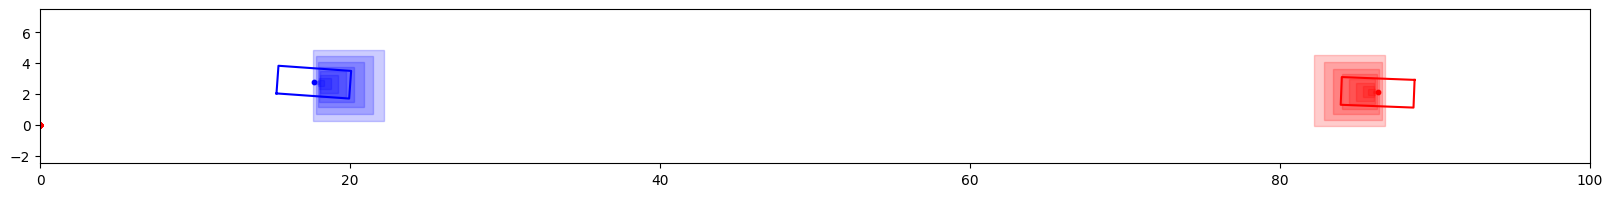

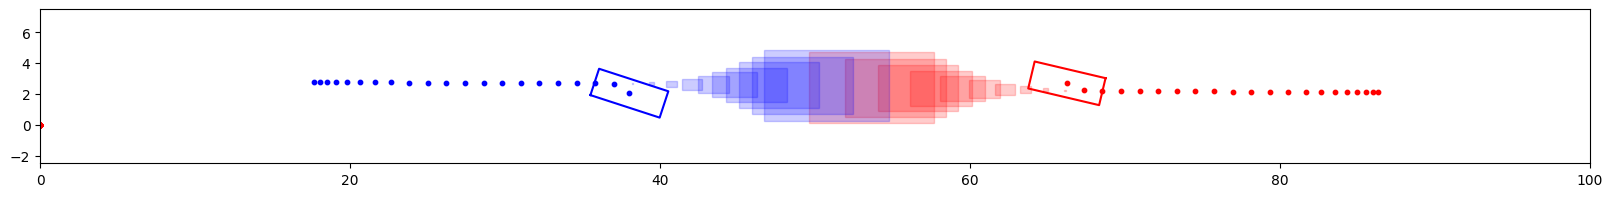

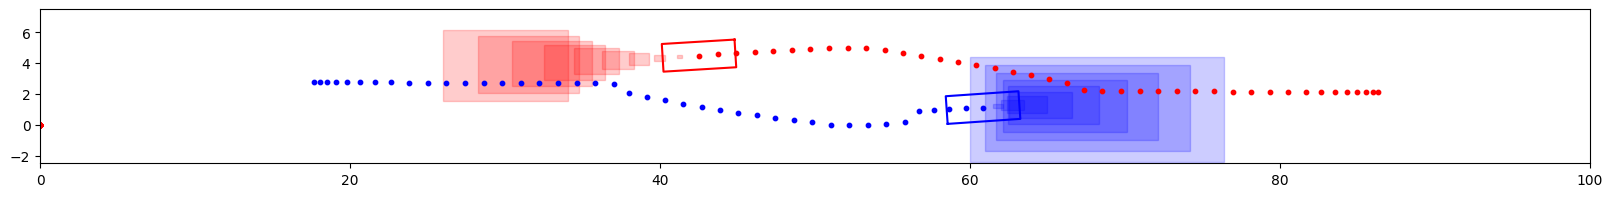

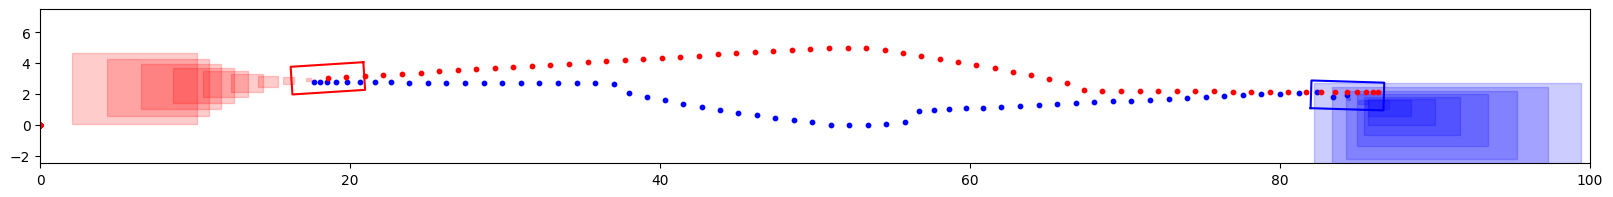

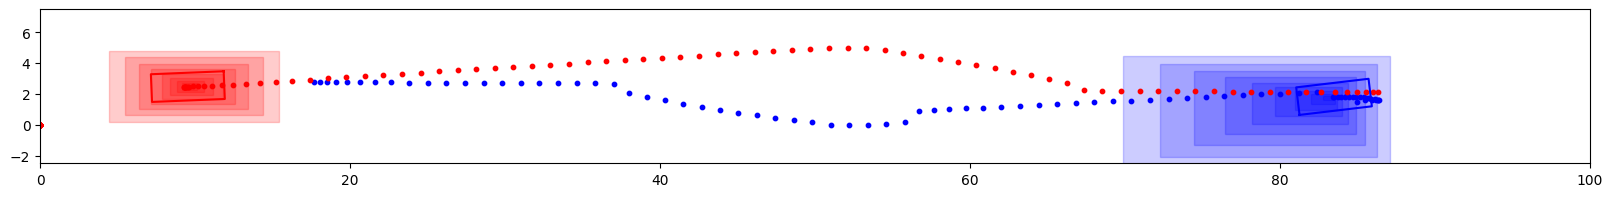

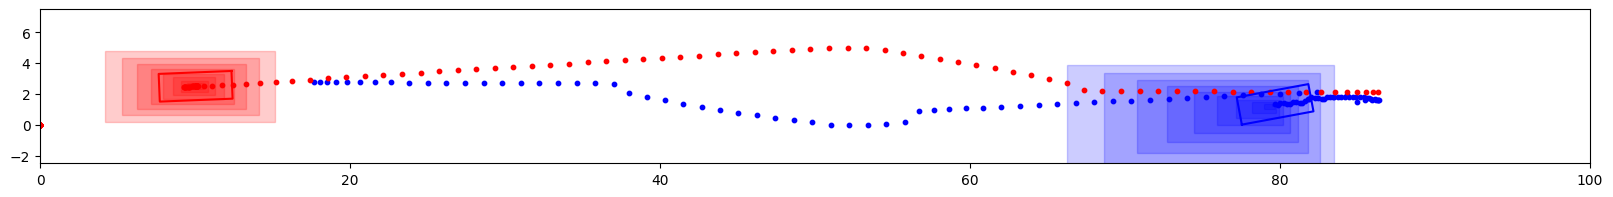

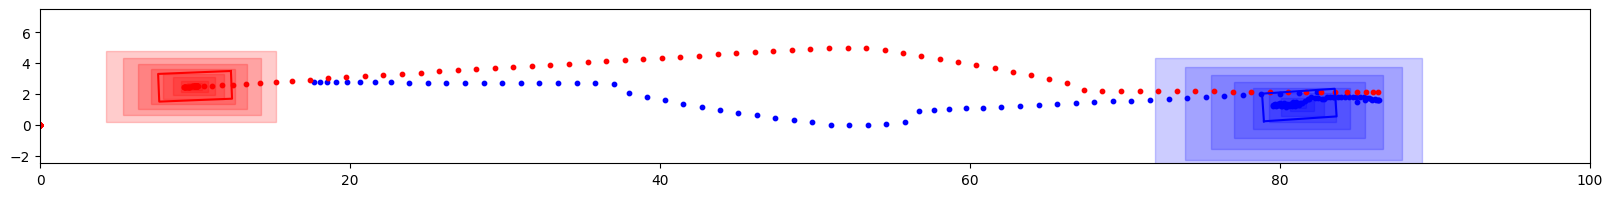

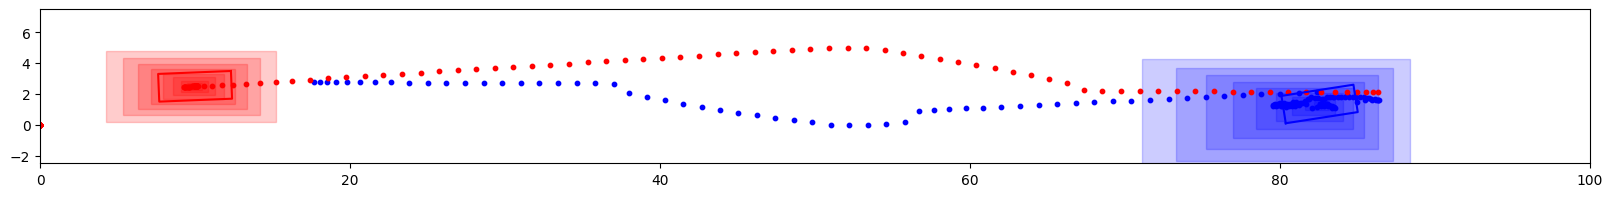

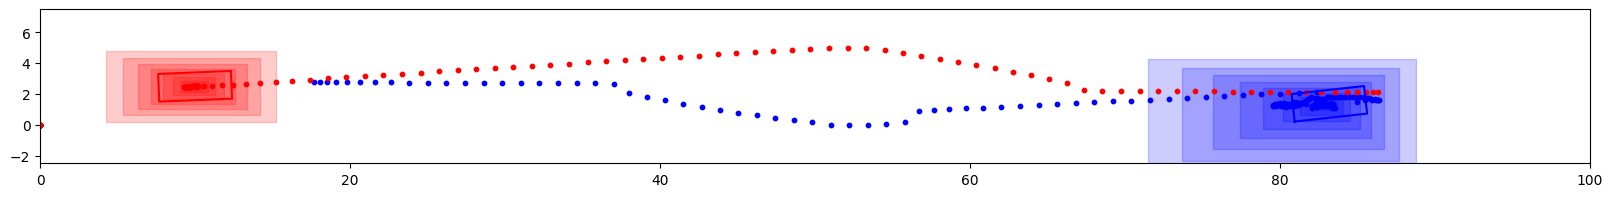

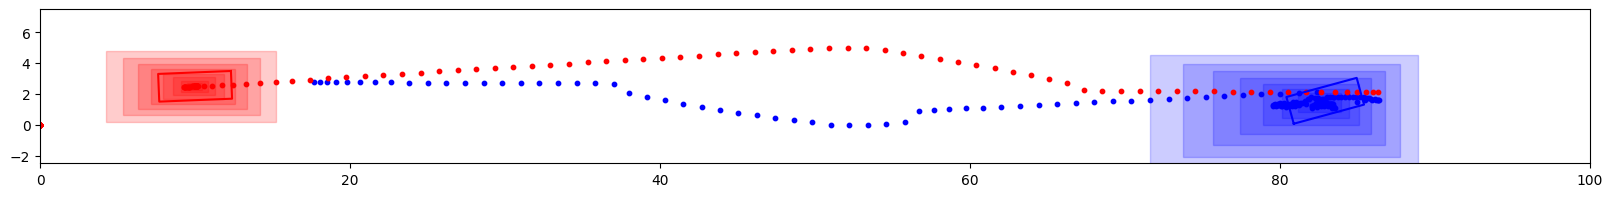

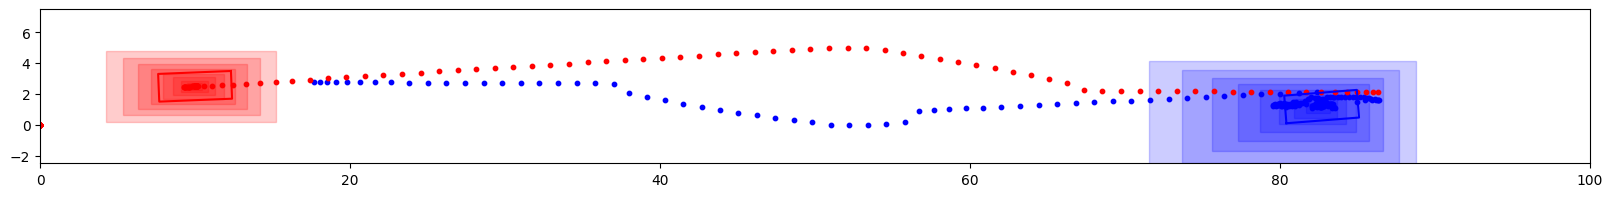

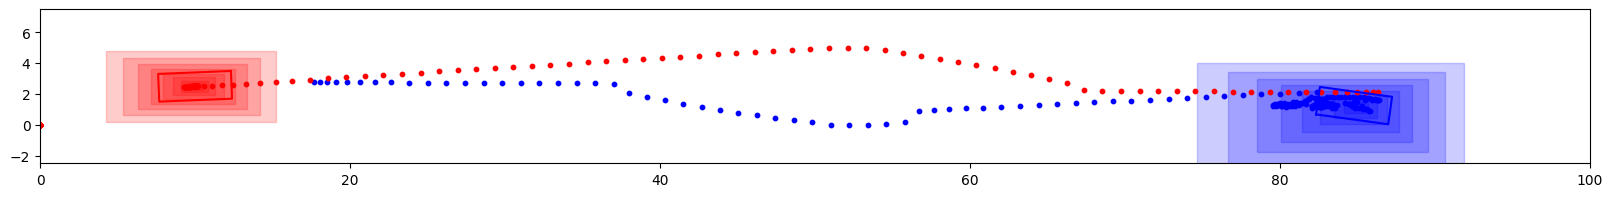

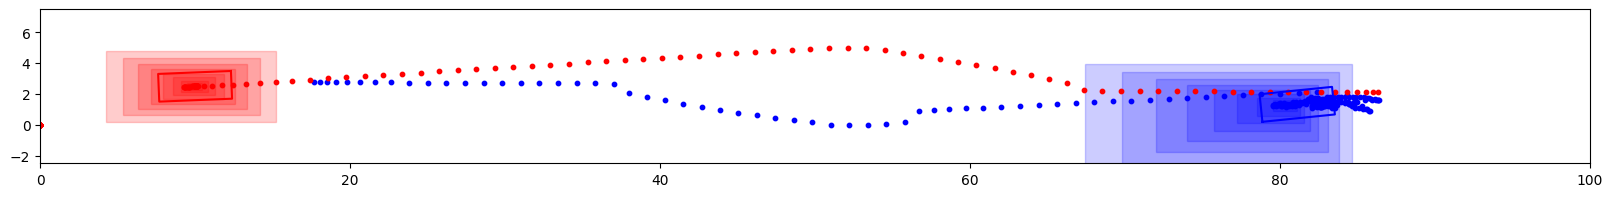

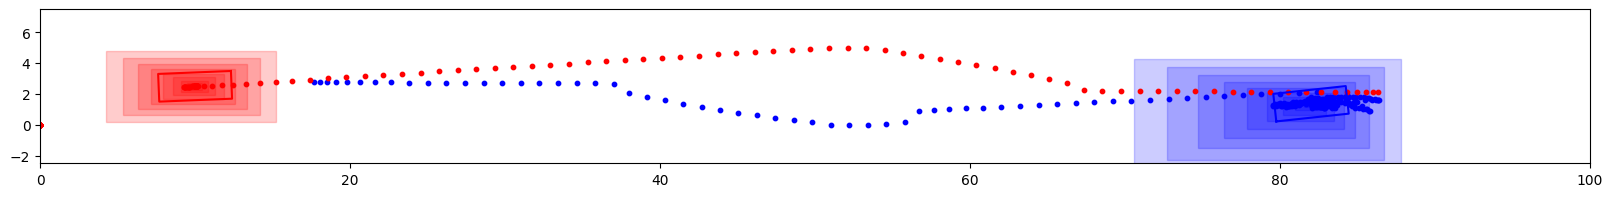

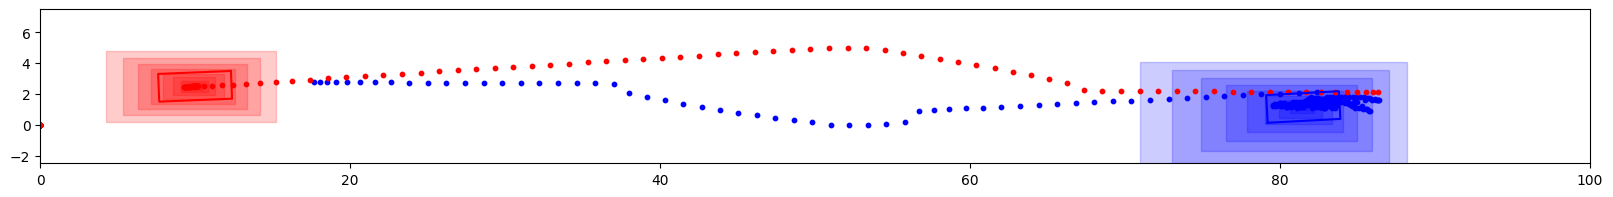

In [284]:
SV = SV_controller(Param_SV)
State_SV_R     = np.zeros((5, simulation_time+1))
State_SV_R[:, 0] = SV_initial
SV_Planning_R = list( )
half_width_sv = Param_SV["w_veh"] / 2
half_length_sv = Param_SV["l_veh"] / 2

EV = SV_controller(Param_EV)
State_EV_R     = np.zeros((5, simulation_time+1))
State_EV_R[:, 0] = EV_initial
EV_Planning_R = list( )
half_width_ev = Param_EV["w_veh"] / 2
half_length_ev = Param_EV["l_veh"] / 2

ratio = 10
for i in range(0,simulation_time):
    SV_phi = State_SV_R[2, i]
    SV_acc = np.array([State_SV_R[4, i]*np.cos(SV_phi),State_SV_R[4, i]*np.sin(SV_phi)])
    SV_pos = np.array([State_SV_R[0, i],State_SV_R[1, i]])
    SV_vel = np.array([State_SV_R[3, i]*np.cos(SV_phi),State_SV_R[3, i]*np.sin(SV_phi)])
    EV_phi = State_EV_R[2, i]
    EV_acc = np.array([State_EV_R[4, i]*np.cos(EV_phi),State_EV_R[4, i]*np.sin(EV_phi)])
    EV_pos = np.array([State_EV_R[0, i],State_EV_R[1, i]])
    EV_vel = np.array([State_EV_R[3, i]*np.cos(EV_phi),State_EV_R[3, i]*np.sin(EV_phi)])
    distance = np.linalg.norm(EV_pos - SV_pos)

    #input:acc,pos,vel
    U_R_SV, trajectory_planning_k_SV, J_R_SV, Occupancy_SV_aug_R,_  = SV.Return(EV_acc.reshape(2,1),
                                                                                        EV_pos.reshape(2,1),
                                                                                        EV_vel.reshape(2,1),
                                                                                        EV_phi,
                                                                                        State_SV_R[:, i])
    U_R_EV, trajectory_planning_k_EV, J_R_EV, Occupancy_EV_aug_R,_  = EV.Return(SV_acc.reshape(2,1),
                                                                                        SV_pos.reshape(2,1),
                                                                                        SV_vel.reshape(2,1), 
                                                                                        SV_phi,
                                                                                        State_EV_R[:, i])

    SV_Planning_R.append(trajectory_planning_k_SV[0:2,1].reshape(2,1))
    State_SV_R[:, i + 1] = trajectory_planning_k_SV[:, 1]
    EV_Planning_R.append(trajectory_planning_k_EV[0:2,1].reshape(2,1))
    State_EV_R[:, i + 1] = trajectory_planning_k_EV[:, 1]
    # if i  == 1 or i == simulation_time-1: 
    if i  % 20 == 0: 
        fig, ax = plt.subplots(figsize=(ratio*2, 2))
        corners_sv = np.array([
            [-half_length_sv, -half_width_sv],
            [half_length_sv, -half_width_sv],
            [half_length_sv, half_width_sv],
            [-half_length_sv, half_width_sv]
        ])
        rad_yaw_sv = trajectory_planning_k_SV[2,1]
        rotation_matrix_sv = np.array([
                [np.cos(rad_yaw_sv), -np.sin(rad_yaw_sv)],
                [np.sin(rad_yaw_sv),  np.cos(rad_yaw_sv)]
            ])
        rotated_corners_sv = corners_sv.reshape(4,2) @ rotation_matrix_sv.T
        rotated_corners_sv[:, 0] += State_SV_R[0,i+1]
        rotated_corners_sv[:, 1] += State_SV_R[1,i+1]
        rotated_corners_sv = np.vstack([rotated_corners_sv, rotated_corners_sv[0]])
        plt.plot(rotated_corners_sv[:, 0], rotated_corners_sv[:, 1], 'r-')

        corners_ev = np.array([
            [-half_length_ev, -half_width_ev],
            [half_length_ev, -half_width_ev],
            [half_length_ev, half_width_ev],
            [-half_length_ev, half_width_ev]
        ])
        rad_yaw_ev = trajectory_planning_k_EV[2,1]
        rotation_matrix_ev = np.array([
                [np.cos(rad_yaw_ev), -np.sin(rad_yaw_ev)],
                [np.sin(rad_yaw_ev),  np.cos(rad_yaw_ev)]
            ])
        rotated_corners_ev = corners_ev.reshape(4,2) @ rotation_matrix_ev.T
        rotated_corners_ev[:, 0] += State_EV_R[0,i+1]
        rotated_corners_ev[:, 1] += State_EV_R[1,i+1]
        rotated_corners_ev = np.vstack([rotated_corners_ev, rotated_corners_ev[0]])
        plt.plot(rotated_corners_ev[:, 0], rotated_corners_ev[:, 1], 'b-')
        
        for i in range(len(Occupancy_EV_aug_R)):
            occupancy = Polytope(Occupancy_EV_aug_R[i].A, Occupancy_EV_aug_R[i].b)
            occupancy.plot(color='r', alpha=0.2)
        for i in range(len(Occupancy_SV_aug_R)):
            occupancy = Polytope(Occupancy_SV_aug_R[i].A, Occupancy_SV_aug_R[i].b)
            occupancy.plot(color='b', alpha=0.2)

        plt.scatter(State_EV_R[0,1:], State_EV_R[1,1:], color='blue', s=10)
        plt.scatter(State_SV_R[0,1:], State_SV_R[1,1:], color='red', s=10)
        ax.set_xlim([x_low,x_up])
        ax.set_ylim([y_low-2.5,y_up+2.5])
        plt.show()

In [285]:
# Setup the figure and animation
fig, ax = plt.subplots(figsize=(ratio*2, 2))
frames = []

SV = EV_controller(Param_SV)
State_SV_R = np.zeros((5, simulation_time+1))
State_SV_R[:, 0] = SV_initial
SV_Planning_R = list()
half_width_sv = Param_SV["w_veh"] / 2
half_length_sv = Param_SV["l_veh"] / 2

EV = EV_controller(Param_EV)
State_EV_R = np.zeros((5, simulation_time+1))
State_EV_R[:, 0] = EV_initial
EV_Planning_R = list()
half_width_ev = Param_EV["w_veh"] / 2
half_length_ev = Param_EV["l_veh"] / 2

# Function to animate each frame
def animate(i):
    ax.clear()
    
    SV_phi = State_SV_R[2, i]
    SV_acc = np.array([State_SV_R[4, i]*np.cos(SV_phi),State_SV_R[4, i]*np.sin(SV_phi)])
    SV_pos = np.array([State_SV_R[0, i],State_SV_R[1, i]])
    SV_vel = np.array([State_SV_R[3, i]*np.cos(SV_phi),State_SV_R[3, i]*np.sin(SV_phi)])
    EV_phi = State_EV_R[2, i]
    EV_acc = np.array([State_EV_R[4, i]*np.cos(EV_phi),State_EV_R[4, i]*np.sin(EV_phi)])
    EV_pos = np.array([State_EV_R[0, i],State_EV_R[1, i]])
    EV_vel = np.array([State_EV_R[3, i]*np.cos(EV_phi),State_EV_R[3, i]*np.sin(EV_phi)])
    
    U_R_SV, trajectory_planning_k_SV, J_R_SV, Occupancy_SV_aug_R,_ = SV.Return(EV_acc.reshape(2,1),
                                                                                    EV_pos.reshape(2,1),
                                                                                    EV_vel.reshape(2,1),
                                                                                    EV_phi,
                                                                                    State_SV_R[:, i])
    U_R_EV, trajectory_planning_k_EV, J_R_EV, Occupancy_EV_aug_R,_ = EV.Return(SV_acc.reshape(2,1),
                                                                                    SV_pos.reshape(2,1),
                                                                                    SV_vel.reshape(2,1), 
                                                                                    SV_phi,
                                                                                    State_EV_R[:, i])

    SV_Planning_R.append(trajectory_planning_k_SV[0:2,1].reshape(2,1))
    State_SV_R[:, i + 1] = trajectory_planning_k_SV[:, 1]
    EV_Planning_R.append(trajectory_planning_k_EV[0:2,1].reshape(2,1))
    State_EV_R[:, i + 1] = trajectory_planning_k_EV[:, 1]

    # Draw vehicles
    corners_sv = np.array([
        [-half_length_sv, -half_width_sv],
        [half_length_sv, -half_width_sv],
        [half_length_sv, half_width_sv],
        [-half_length_sv, half_width_sv]
    ])
    rad_yaw_sv = trajectory_planning_k_SV[2,1]
    rotation_matrix_sv = np.array([
            [np.cos(rad_yaw_sv), -np.sin(rad_yaw_sv)],
            [np.sin(rad_yaw_sv), np.cos(rad_yaw_sv)]
        ])
    rotated_corners_sv = corners_sv.reshape(4,2) @ rotation_matrix_sv.T
    rotated_corners_sv[:, 0] += State_SV_R[0,i+1]
    rotated_corners_sv[:, 1] += State_SV_R[1,i+1]
    rotated_corners_sv = np.vstack([rotated_corners_sv, rotated_corners_sv[0]])
    ax.plot(rotated_corners_sv[:, 0], rotated_corners_sv[:, 1], 'r-')

    corners_ev = np.array([
        [-half_length_ev, -half_width_ev],
        [half_length_ev, -half_width_ev],
        [half_length_ev, half_width_ev],
        [-half_length_ev, half_width_ev]
    ])
    rad_yaw_ev = trajectory_planning_k_EV[2,1]
    rotation_matrix_ev = np.array([
            [np.cos(rad_yaw_ev), -np.sin(rad_yaw_ev)],
            [np.sin(rad_yaw_ev), np.cos(rad_yaw_ev)]
        ])
    rotated_corners_ev = corners_ev.reshape(4,2) @ rotation_matrix_ev.T
    rotated_corners_ev[:, 0] += State_EV_R[0,i+1]
    rotated_corners_ev[:, 1] += State_EV_R[1,i+1]
    rotated_corners_ev = np.vstack([rotated_corners_ev, rotated_corners_ev[0]])
    ax.plot(rotated_corners_ev[:, 0], rotated_corners_ev[:, 1], 'b-')
    
    # Draw reachable sets
    for j in range(len(Occupancy_EV_aug_R)):
        occupancy = Polytope(Occupancy_EV_aug_R[j].A, Occupancy_EV_aug_R[j].b)
        occupancy.plot(color='r', alpha=0.2)
    for j in range(len(Occupancy_SV_aug_R)):
        occupancy = Polytope(Occupancy_SV_aug_R[j].A, Occupancy_SV_aug_R[j].b)
        occupancy.plot(color='b', alpha=0.2)

    # Draw trajectories
    ax.scatter(State_EV_R[0,1:i+1], State_EV_R[1,1:i+1], color='b', s=1)
    ax.scatter(State_SV_R[0,1:i+1], State_SV_R[1,1:i+1], color='r', s=1)
    
    # Set plot limits and title
    ax.set_xlim([x_low,x_up])
    ax.set_ylim([y_low-2.5,y_up+2.5])
    ax.set_title(f'Time step: {i}')
    ax.grid(True)

# Create animation
anim = FuncAnimation(fig, animate, frames=simulation_time, interval=50, blit=False)

# Save animation
anim.save('simulation_risk.mp4', writer='ffmpeg', fps=20)
plt.close()

QhullError: QH6347 qhull precision error (qh_mergefacet): wide merge for facet f1763 into f203 for mergetype 10 (degen).  maxdist  0 (0.0x) mindist -0.094 (74600852245.3x) vertexdist  3  Allow with 'Q12' (allow-wide)
ERRONEOUS FACET:
- f1763
    - flags: top newfacet mergeridge1 newmerge
    - merges: 3
    - normal:  -1.762e-17 7.188e-17   0.4402  -0.8979
    - offset:  -3.084021
    - vertices: p838(v118) p439(v78) p458(v71) p770(v41) p773(v13)
    - neighboring facets: f203
    - ridges:
     - r715 tested simplicialtop
           vertices: p439(v78) p458(v71) p770(v41)
           between f1763 and f203
     - r711
           vertices: p458(v71) p770(v41) p773(v13)
           between f203 and f1763
     - r243
           vertices: p439(v78) p770(v41) p773(v13)
           between f1763 and f203
     - r282
           vertices: p439(v78) p458(v71) p773(v13)
           between f203 and f1763
ERRONEOUS OTHER FACET:
- f203
    - flags: top tested keepcentrum
    - merges: 35
    - normal:  -1.695e-17 2.237e-17   0.4856  -0.8742
    - offset:  -3.179381
    - center: 79.7618447956277 -7.50721412453553 3.819856420278501 -1.514938359818675 
    - coplanar set: p518 p777 p782 p788 p763 p522 p525 p513
      furthest distance= 4e-16
    - vertices: p846(v117) p453(v107) p435(v106) p860(v98) p836(v79) p439(v78) p458(v71) p533(v64) p859(v54) p831(v52) p454(v49) p770(v41) p858(v28) p480(v23) p773(v13)
    - neighboring facets: f1594 f910 f1732 f1588 f284 f1748 f1756 f1726 f1568 f461 f797 f1591 f1062 f1741 f1739 f1782 f1764 f1766 f1763
    - ridges:
     - r1374 tested simplicialtop
           vertices: p435(v106) p439(v78) p831(v52)
           between f1594 and f203
     - r704 tested simplicialbot
           vertices: p458(v71) p533(v64) p480(v23)
           between f203 and f910
     - r1569 tested simplicialtop
           vertices: p846(v117) p859(v54) p858(v28)
           between f1732 and f203
     - r1367 tested simplicialbot
           vertices: p435(v106) p439(v78) p454(v49)
           between f203 and f1588
     - r146 tested
           vertices: p435(v106) p858(v28) p480(v23)
           between f284 and f203
     - r330 tested
           vertices: p435(v106) p454(v49) p480(v23)
           between f203 and f284
     - r430 tested simplicialbot
           vertices: p859(v54) p858(v28) p480(v23)
           between f203 and f284
     - r923 tested
           vertices: p435(v106) p836(v79) p858(v28)
           between f284 and f203
     - r1233 tested
           vertices: p860(v98) p859(v54) p480(v23)
           between f203 and f284
     - r1559 tested simplicialtop
           vertices: p846(v117) p836(v79) p831(v52)
           between f1748 and f203
     - r404 tested simplicialtop
           vertices: p439(v78) p458(v71) p831(v52)
           between f1756 and f203
     - r1558 tested simplicialbot
           vertices: p846(v117) p836(v79) p858(v28)
           between f203 and f1726
     - r700 tested simplicialtop
           vertices: p458(v71) p454(v49) p480(v23)
           between f1568 and f203
     - r1382 tested
           vertices: p453(v107) p458(v71) p454(v49)
           between f203 and f461
     - r1226 tested
           vertices: p860(v98) p533(v64) p480(v23)
           between f797 and f203
     - r1375 tested simplicialbot
           vertices: p435(v106) p836(v79) p831(v52)
           between f203 and f1591
     - r1391 tested
           vertices: p453(v107) p439(v78) p454(v49)
           between f1062 and f203
     - r1574 tested simplicialbot
           vertices: p846(v117) p860(v98) p533(v64)
           between f203 and f1741
     - r1573 tested
           vertices: p846(v117) p860(v98) p859(v54)
           between f1739 and f203
     - r1561 tested simplicialbot
           vertices: p846(v117) p533(v64) p831(v52)
           between f203 and f1782
     - r620 tested simplicialtop
           vertices: p458(v71) p533(v64) p831(v52)
           between f1764 and f203
     - r1387 tested simplicialbot
           vertices: p453(v107) p439(v78) p458(v71)
           between f203 and f1766
     - r282
           vertices: p439(v78) p458(v71) p773(v13)
           between f203 and f1763
     - r715 tested simplicialtop
           vertices: p439(v78) p458(v71) p770(v41)
           between f1763 and f203
     - r243
           vertices: p439(v78) p770(v41) p773(v13)
           between f1763 and f203
     - r711
           vertices: p458(v71) p770(v41) p773(v13)
           between f203 and f1763

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1529806502  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 17  Error-roundoff 1.3e-13  _one-merge 1.1e-12
  _near-inside 5.6e-12  Visible-distance 7.5e-13  U-max-coplanar 7.5e-13
  Width-outside 1.5e-12  _wide-facet 4.5e-12  _maxoutside 1.5e-12
Last point added to hull was p838.  Last merge was #574.

At error exit:

Convex hull of 1296 points in 4-d:

  Number of vertices: 100
  Number of coplanar points: 255
  Number of facets: 277
  Number of non-simplicial facets: 57

Statistics for:  | qhull i Qt

  Number of points processed: 118
  Number of hyperplanes created: 1236
  Number of distance tests for qhull: 49859
  Number of distance tests for merging: 13875
  Number of distance tests for checking: 0
  Number of merged facets: 589


precision problems (corrected unless 'Q0' or an error)
      2 flipped facets
    332 coplanar horizon facets for new vertices
    264 coplanar points during partitioning
      1 dupridges with flip facet into good neighbor

A wide merge error has occurred.  Qhull has produced a wide facet due to facet merges and vertex merges.
This usually occurs when the input is nearly degenerate and substantial merging has occurred.
See http://www.qhull.org/html/qh-impre.htm#limit


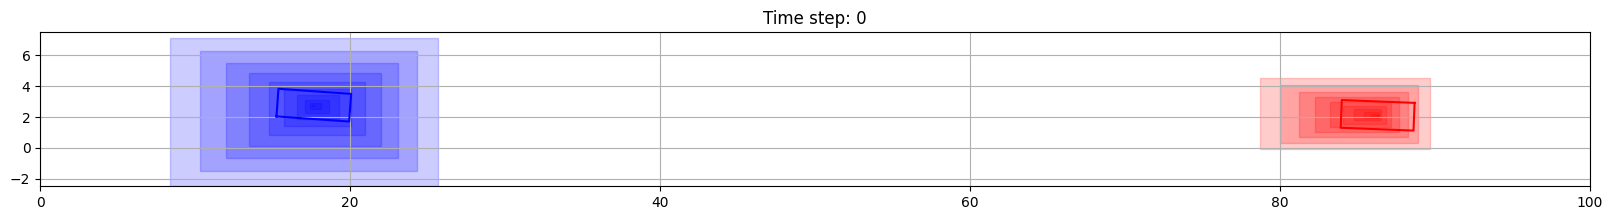

In [286]:
# Setup the figure and animation
fig, ax = plt.subplots(figsize=(ratio*2, 2))
frames = []

SV = SV_controller(Param_SV)
State_SV_R = np.zeros((5, simulation_time+1))
State_SV_R[:, 0] = SV_initial
SV_Planning_R = list()
half_width_sv = Param_SV["w_veh"] / 2
half_length_sv = Param_SV["l_veh"] / 2

EV = SV_controller(Param_EV)
State_EV_R = np.zeros((5, simulation_time+1))
State_EV_R[:, 0] = EV_initial
EV_Planning_R = list()
half_width_ev = Param_EV["w_veh"] / 2
half_length_ev = Param_EV["l_veh"] / 2

# Function to animate each frame
def animate(i):
    ax.clear()
    
    SV_phi = State_SV_R[2, i]
    SV_acc = np.array([State_SV_R[4, i]*np.cos(SV_phi),State_SV_R[4, i]*np.sin(SV_phi)])
    SV_pos = np.array([State_SV_R[0, i],State_SV_R[1, i]])
    SV_vel = np.array([State_SV_R[3, i]*np.cos(SV_phi),State_SV_R[3, i]*np.sin(SV_phi)])
    EV_phi = State_EV_R[2, i]
    EV_acc = np.array([State_EV_R[4, i]*np.cos(EV_phi),State_EV_R[4, i]*np.sin(EV_phi)])
    EV_pos = np.array([State_EV_R[0, i],State_EV_R[1, i]])
    EV_vel = np.array([State_EV_R[3, i]*np.cos(EV_phi),State_EV_R[3, i]*np.sin(EV_phi)])
    
    U_R_SV, trajectory_planning_k_SV, J_R_SV, Occupancy_SV_aug_R,_ = SV.Return(EV_acc.reshape(2,1),
                                                                                    EV_pos.reshape(2,1),
                                                                                    EV_vel.reshape(2,1),
                                                                                    EV_phi,
                                                                                    State_SV_R[:, i])
    U_R_EV, trajectory_planning_k_EV, J_R_EV, Occupancy_EV_aug_R,_ = EV.Return(SV_acc.reshape(2,1),
                                                                                    SV_pos.reshape(2,1),
                                                                                    SV_vel.reshape(2,1), 
                                                                                    SV_phi,
                                                                                    State_EV_R[:, i])

    SV_Planning_R.append(trajectory_planning_k_SV[0:2,1].reshape(2,1))
    State_SV_R[:, i + 1] = trajectory_planning_k_SV[:, 1]
    EV_Planning_R.append(trajectory_planning_k_EV[0:2,1].reshape(2,1))
    State_EV_R[:, i + 1] = trajectory_planning_k_EV[:, 1]

    # Draw vehicles
    corners_sv = np.array([
        [-half_length_sv, -half_width_sv],
        [half_length_sv, -half_width_sv],
        [half_length_sv, half_width_sv],
        [-half_length_sv, half_width_sv]
    ])
    rad_yaw_sv = trajectory_planning_k_SV[2,1]
    rotation_matrix_sv = np.array([
            [np.cos(rad_yaw_sv), -np.sin(rad_yaw_sv)],
            [np.sin(rad_yaw_sv), np.cos(rad_yaw_sv)]
        ])
    rotated_corners_sv = corners_sv.reshape(4,2) @ rotation_matrix_sv.T
    rotated_corners_sv[:, 0] += State_SV_R[0,i+1]
    rotated_corners_sv[:, 1] += State_SV_R[1,i+1]
    rotated_corners_sv = np.vstack([rotated_corners_sv, rotated_corners_sv[0]])
    ax.plot(rotated_corners_sv[:, 0], rotated_corners_sv[:, 1], 'r-')

    corners_ev = np.array([
        [-half_length_ev, -half_width_ev],
        [half_length_ev, -half_width_ev],
        [half_length_ev, half_width_ev],
        [-half_length_ev, half_width_ev]
    ])
    rad_yaw_ev = trajectory_planning_k_EV[2,1]
    rotation_matrix_ev = np.array([
            [np.cos(rad_yaw_ev), -np.sin(rad_yaw_ev)],
            [np.sin(rad_yaw_ev), np.cos(rad_yaw_ev)]
        ])
    rotated_corners_ev = corners_ev.reshape(4,2) @ rotation_matrix_ev.T
    rotated_corners_ev[:, 0] += State_EV_R[0,i+1]
    rotated_corners_ev[:, 1] += State_EV_R[1,i+1]
    rotated_corners_ev = np.vstack([rotated_corners_ev, rotated_corners_ev[0]])
    ax.plot(rotated_corners_ev[:, 0], rotated_corners_ev[:, 1], 'b-')
    
    # Draw reachable sets
    for j in range(len(Occupancy_EV_aug_R)):
        occupancy = Polytope(Occupancy_EV_aug_R[j].A, Occupancy_EV_aug_R[j].b)
        occupancy.plot(color='r', alpha=0.2)
    for j in range(len(Occupancy_SV_aug_R)):
        occupancy = Polytope(Occupancy_SV_aug_R[j].A, Occupancy_SV_aug_R[j].b)
        occupancy.plot(color='b', alpha=0.2)

    # Draw trajectories
    ax.scatter(State_EV_R[0,1:i+1], State_EV_R[1,1:i+1], color='b', s=1)
    ax.scatter(State_SV_R[0,1:i+1], State_SV_R[1,1:i+1], color='r', s=1)
    
    # Set plot limits and title
    ax.set_xlim([x_low,x_up])
    ax.set_ylim([y_low-2.5,y_up+2.5])
    ax.set_title(f'Time step: {i}')
    ax.grid(True)

# Create animation
anim = FuncAnimation(fig, animate, frames=simulation_time, interval=50, blit=False)

# Save animation
anim.save('simulation.mp4', writer='ffmpeg', fps=20)
plt.close()

In [238]:
def generate_random_initial_state(x_range, y_range, phi_range, v_range, a_range):
    """Generate random initial state within specified ranges
    
    Args:
        x_range (tuple): (min, max) range for x position
        y_range (tuple): (min, max) range for y position 
        phi_range (tuple): (min, max) range for heading angle
        v_range (tuple): (min, max) range for velocity
        a_range (tuple): (min, max) range for acceleration
        
    Returns:
        np.array: Random initial state [x, y, phi, v, a]
    """
    return np.array([
        np.random.uniform(*x_range),    # x position
        np.random.uniform(*y_range),    # y position
        np.random.uniform(*phi_range),  # heading angle
        np.random.uniform(*v_range),    # velocity
        np.random.uniform(*a_range)     # acceleration
    ])

def run_monte_carlo_simulation(num_trials, Param_SV, Param_EV):
    # Store results for each trial
    results = {
        'success_count': 0,  # Count of successful arrivals
        'min_distances': [],
        'completion_times': [],
        'trajectories_SV': [],
        'trajectories_EV': [],
        'failed_trials': 0  # Add counter for failed trials
    }
    
    # Add progress bar
    pbar = tqdm(range(num_trials), desc='Running Monte Carlo Trials')
    
    for trial in pbar:
        max_retries = 5  # Maximum number of retry attempts
        retry_count = 0
        success = False
        
        while retry_count < max_retries and not success:
            try:
                # Randomize initial conditions
                # For SV (Subject Vehicle)
                SV_initial = generate_random_initial_state(
                    x_range=(60, 80),      # Starting further back
                    y_range=(1, 5),        # Within road bounds
                    phi_range=(3.0, 3.28), # Roughly pointing left
                    v_range=(0.8, 1.2),    # Around 1 m/s
                    a_range=(-0.1, 0.1)    # Small initial acceleration
                )

                # For EV (Ego Vehicle) 
                EV_initial = generate_random_initial_state(
                    x_range=(20, 40),      # Starting in middle
                    y_range=(1, 5),        # Within road bounds
                    phi_range=(0.05,0.2),  # Roughly pointing right
                    v_range=(0.8, 1.2),    # Around 1 m/s
                    a_range=(-0.1, 0.1)    # Small initial acceleration
                )

                # Run single simulation
                trial_results = run_single_simulation(SV_initial, EV_initial, Param_SV, Param_EV)
                
                # Store results
                results['min_distances'].append(trial_results['min_distance'])
                results['completion_times'].append(trial_results['completion_time'])
                results['trajectories_SV'].append(trial_results['trajectory_SV'])
                results['trajectories_EV'].append(trial_results['trajectory_EV'])
                
                if trial_results['success']:
                    results['success_count'] += 1
                
                success = True  # Mark as successful to exit retry loop
                
            except Exception as e:
                retry_count += 1
                if retry_count < max_retries:
                    print(f"\nTrial {trial} failed (attempt {retry_count}/{max_retries}). Error: {str(e)}")
                    print("Retrying with new random initial conditions...")
                else:
                    print(f"\nTrial {trial} failed after {max_retries} attempts. Moving to next trial.")
                    results['failed_trials'] += 1
        
        # Update progress bar with success rate and failure count
        pbar.set_postfix({
            'Success Rate': f"{(results['success_count']/(trial+1))*100:.1f}%",
            'Failed Trials': results['failed_trials']
        })
            
    return results

def run_single_simulation(SV_initial, EV_initial, Param_SV, Param_EV):
    """Run a single simulation with given initial conditions"""
    SV = EV_controller(Param_SV)
    State_SV_R = np.zeros((5, simulation_time+1))
    State_SV_R[:, 0] = SV_initial
    
    EV = EV_controller(Param_EV)
    State_EV_R = np.zeros((5, simulation_time+1))
    State_EV_R[:, 0] = EV_initial
    
    min_distance = float('inf')
    success = False
    completion_time = simulation_time
    
    # Define goal positions and tolerance
    goal_SV = Param_SV["RefPos"]
    goal_EV = Param_EV["RefPos"]
    position_tolerance = 5.0  # meters
    velocity_tolerance = 0.5  # m/s
    heading_tolerance = 0.1   # radians
    
    for i in range(simulation_time):
        SV_phi = State_SV_R[2, i]
        SV_acc = np.array([State_SV_R[4, i]*np.cos(SV_phi), State_SV_R[4, i]*np.sin(SV_phi)])
        SV_pos = np.array([State_SV_R[0, i], State_SV_R[1, i]])
        SV_vel = np.array([State_SV_R[3, i]*np.cos(SV_phi), State_SV_R[3, i]*np.sin(SV_phi)])
        
        EV_phi = State_EV_R[2, i]
        EV_acc = np.array([State_EV_R[4, i]*np.cos(EV_phi), State_EV_R[4, i]*np.sin(EV_phi)])
        EV_pos = np.array([State_EV_R[0, i], State_EV_R[1, i]])
        EV_vel = np.array([State_EV_R[3, i]*np.cos(EV_phi), State_EV_R[3, i]*np.sin(EV_phi)])
        
        # Calculate distance between vehicles
        distance = np.linalg.norm(EV_pos - SV_pos)
        min_distance = min(min_distance, distance)
        
        # Check if both vehicles have reached their goals
        SV_at_goal = (np.linalg.norm(SV_pos - goal_SV[0:2]) < position_tolerance)
        #print("SV_goal:", np.linalg.norm(SV_pos - goal_SV[0:2]) - position_tolerance)
        EV_at_goal = (np.linalg.norm(EV_pos - goal_EV[0:2]) < position_tolerance)
        #print("EV_goal:", np.linalg.norm(EV_pos - goal_EV[0:2]) - position_tolerance)
        
        if SV_at_goal and EV_at_goal:
            success = True
            completion_time = i
            break
            
        # Update states
        U_R_SV, trajectory_planning_k_SV, _, _, _ = SV.Return(
            EV_acc.reshape(2,1), EV_pos.reshape(2,1), EV_vel.reshape(2,1), EV_phi, State_SV_R[:, i]
        )
        U_R_EV, trajectory_planning_k_EV, _, _, _ = EV.Return(
            SV_acc.reshape(2,1), SV_pos.reshape(2,1), SV_vel.reshape(2,1), SV_phi, State_EV_R[:, i]
        )
        
        State_SV_R[:, i + 1] = trajectory_planning_k_SV[:, 1]
        State_EV_R[:, i + 1] = trajectory_planning_k_EV[:, 1]
    
    return {
        'success': success,
        'min_distance': min_distance,
        'completion_time': completion_time,
        'trajectory_SV': State_SV_R,
        'trajectory_EV': State_EV_R
    }

def analyze_monte_carlo_results(results, num_trials):
    """Analyze and visualize Monte Carlo simulation results"""
    # Calculate statistics
    success_rate = results['success_count'] / num_trials * 100
    avg_min_distance = np.mean(results['min_distances'])
    std_min_distance = np.std(results['min_distances'])
    avg_completion_time = np.mean([t for t in results['completion_times'] if t < simulation_time])
    
    # Plot histograms
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.hist(results['min_distances'], bins=30)
    ax1.set_title('Minimum Distances')
    ax1.set_xlabel('Distance (m)')
    ax1.set_ylabel('Number of Trials')
    
    completion_times = [t for t in results['completion_times'] if t < simulation_time]
    if completion_times:
        ax2.hist(completion_times, bins=30)
        ax2.set_title('Completion Times')
        ax2.set_xlabel('Time steps')
        ax2.set_ylabel('Number of Trials')
    else:
        ax2.text(0.5, 0.5, 'No successful completions', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Monte Carlo Simulation Results ({num_trials} trials):")
    print(f"Success Rate: {success_rate:.2f}%")
    print(f"Average Minimum Distance: {avg_min_distance:.2f} m")
    print(f"Std Dev of Minimum Distance: {std_min_distance:.2f} m")
    if completion_times:
        print(f"Average Completion Time (successful trials): {avg_completion_time:.2f} steps")
    else:
        print("No successful completions")

In [239]:
# Run Monte Carlo analysis with 100 trials
a
trails = 100
analyze_monte_carlo_results(run_monte_carlo_simulation(trails,Param_SV, Param_EV),trails)

NameError: name 'a' is not defined

In [11]:
def generate_random_initial_state(x_range, y_range, phi_range, v_range, a_range):
    """Generate random initial state within specified ranges
    
    Args:
        x_range (tuple): (min, max) range for x position
        y_range (tuple): (min, max) range for y position 
        phi_range (tuple): (min, max) range for heading angle
        v_range (tuple): (min, max) range for velocity
        a_range (tuple): (min, max) range for acceleration
        
    Returns:
        np.array: Random initial state [x, y, phi, v, a]
    """
    return np.array([
        np.random.uniform(*x_range),    # x position
        np.random.uniform(*y_range),    # y position
        np.random.uniform(*phi_range),  # heading angle
        np.random.uniform(*v_range),    # velocity
        np.random.uniform(*a_range)     # acceleration
    ])

def run_monte_carlo_simulation(num_trials, Param_SV, Param_EV):
    # Store results for each trial
    results = {
        'success_count': 0,  # Count of successful arrivals
        'min_distances': [],
        'completion_times': [],
        'trajectories_SV': [],
        'trajectories_EV': [],
        'failed_trials': 0  # Add counter for failed trials
    }
    
    # Add progress bar
    pbar = tqdm(range(num_trials), desc='Running Monte Carlo Trials')
    
    for trial in pbar:
        max_retries = 5  # Maximum number of retry attempts
        retry_count = 0
        success = False
        
        while retry_count < max_retries and not success:
            try:
                # Randomize initial conditions
                # For SV (Subject Vehicle)
                SV_initial = generate_random_initial_state(
                    x_range=(60, 80),      # Starting further back
                    y_range=(1, 5),        # Within road bounds
                    phi_range=(3.0, 3.28), # Roughly pointing left
                    v_range=(0.8, 1.2),    # Around 1 m/s
                    a_range=(-0.1, 0.1)    # Small initial acceleration
                )

                # For EV (Ego Vehicle) 
                EV_initial = generate_random_initial_state(
                    x_range=(20, 40),      # Starting in middle
                    y_range=(1, 5),        # Within road bounds
                    phi_range=(0.05,0.2),  # Roughly pointing right
                    v_range=(0.8, 1.2),    # Around 1 m/s
                    a_range=(-0.1, 0.1)    # Small initial acceleration
                )

                # Run single simulation
                trial_results = run_single_simulation(SV_initial, EV_initial, Param_SV, Param_EV)
                
                # Store results
                results['min_distances'].append(trial_results['min_distance'])
                results['completion_times'].append(trial_results['completion_time'])
                results['trajectories_SV'].append(trial_results['trajectory_SV'])
                results['trajectories_EV'].append(trial_results['trajectory_EV'])
                
                if trial_results['success']:
                    results['success_count'] += 1
                
                success = True  # Mark as successful to exit retry loop
                
            except Exception as e:
                retry_count += 1
                if retry_count < max_retries:
                    print(f"\nTrial {trial} failed (attempt {retry_count}/{max_retries}). Error: {str(e)}")
                    print("Retrying with new random initial conditions...")
                else:
                    print(f"\nTrial {trial} failed after {max_retries} attempts. Moving to next trial.")
                    results['failed_trials'] += 1
        
        # Update progress bar with success rate and failure count
        pbar.set_postfix({
            'Success Rate': f"{(results['success_count']/(trial+1))*100:.1f}%",
            'Failed Trials': results['failed_trials']
        })
            
    return results

def run_single_simulation(SV_initial, EV_initial, Param_SV, Param_EV):
    """Run a single simulation with given initial conditions"""
    SV = SV_controller(Param_SV)
    State_SV_R = np.zeros((5, simulation_time+1))
    State_SV_R[:, 0] = SV_initial
    
    EV = SV_controller(Param_EV)
    State_EV_R = np.zeros((5, simulation_time+1))
    State_EV_R[:, 0] = EV_initial
    
    min_distance = float('inf')
    success = False
    completion_time = simulation_time
    
    # Define goal positions and tolerance
    goal_SV = Param_SV["RefPos"]
    goal_EV = Param_EV["RefPos"]
    position_tolerance = 5.0  # meters
    velocity_tolerance = 0.5  # m/s
    heading_tolerance = 0.1   # radians
    
    for i in range(simulation_time):
        SV_phi = State_SV_R[2, i]
        SV_acc = np.array([State_SV_R[4, i]*np.cos(SV_phi), State_SV_R[4, i]*np.sin(SV_phi)])
        SV_pos = np.array([State_SV_R[0, i], State_SV_R[1, i]])
        SV_vel = np.array([State_SV_R[3, i]*np.cos(SV_phi), State_SV_R[3, i]*np.sin(SV_phi)])
        
        EV_phi = State_EV_R[2, i]
        EV_acc = np.array([State_EV_R[4, i]*np.cos(EV_phi), State_EV_R[4, i]*np.sin(EV_phi)])
        EV_pos = np.array([State_EV_R[0, i], State_EV_R[1, i]])
        EV_vel = np.array([State_EV_R[3, i]*np.cos(EV_phi), State_EV_R[3, i]*np.sin(EV_phi)])
        
        # Calculate distance between vehicles
        distance = np.linalg.norm(EV_pos - SV_pos)
        min_distance = min(min_distance, distance)
        
        # Check if both vehicles have reached their goals
        SV_at_goal = (np.linalg.norm(SV_pos - goal_SV[0:2]) < position_tolerance)
        #print("SV_goal:", np.linalg.norm(SV_pos - goal_SV[0:2]) - position_tolerance)
        EV_at_goal = (np.linalg.norm(EV_pos - goal_EV[0:2]) < position_tolerance)
        #print("EV_goal:", np.linalg.norm(EV_pos - goal_EV[0:2]) - position_tolerance)
        
        if SV_at_goal and EV_at_goal:
            success = True
            completion_time = i
            break
            
        # Update states
        U_R_SV, trajectory_planning_k_SV, _, _, _ = SV.Return(
            EV_acc.reshape(2,1), EV_pos.reshape(2,1), EV_vel.reshape(2,1), EV_phi, State_SV_R[:, i]
        )
        U_R_EV, trajectory_planning_k_EV, _, _, _ = EV.Return(
            SV_acc.reshape(2,1), SV_pos.reshape(2,1), SV_vel.reshape(2,1), SV_phi, State_EV_R[:, i]
        )
        
        State_SV_R[:, i + 1] = trajectory_planning_k_SV[:, 1]
        State_EV_R[:, i + 1] = trajectory_planning_k_EV[:, 1]
    
    return {
        'success': success,
        'min_distance': min_distance,
        'completion_time': completion_time,
        'trajectory_SV': State_SV_R,
        'trajectory_EV': State_EV_R
    }

def analyze_monte_carlo_results(results, num_trials):
    """Analyze and visualize Monte Carlo simulation results"""
    # Calculate statistics
    success_rate = results['success_count'] / num_trials * 100
    avg_min_distance = np.mean(results['min_distances'])
    std_min_distance = np.std(results['min_distances'])
    avg_completion_time = np.mean([t for t in results['completion_times'] if t < simulation_time])
    
    # Plot histograms
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.hist(results['min_distances'], bins=30)
    ax1.set_title('Minimum Distances')
    ax1.set_xlabel('Distance (m)')
    ax1.set_ylabel('Number of Trials')
    
    completion_times = [t for t in results['completion_times'] if t < simulation_time]
    if completion_times:
        ax2.hist(completion_times, bins=30)
        ax2.set_title('Completion Times')
        ax2.set_xlabel('Time steps')
        ax2.set_ylabel('Number of Trials')
    else:
        ax2.text(0.5, 0.5, 'No successful completions', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Monte Carlo Simulation Results ({num_trials} trials):")
    print(f"Success Rate: {success_rate:.2f}%")
    print(f"Average Minimum Distance: {avg_min_distance:.2f} m")
    print(f"Std Dev of Minimum Distance: {std_min_distance:.2f} m")
    if completion_times:
        print(f"Average Completion Time (successful trials): {avg_completion_time:.2f} steps")
    else:
        print("No successful completions")

Running Monte Carlo Trials: 100%|██████████| 100/100 [2:00:36<00:00, 72.37s/it, Success Rate=14.0%, Failed Trials=0] 


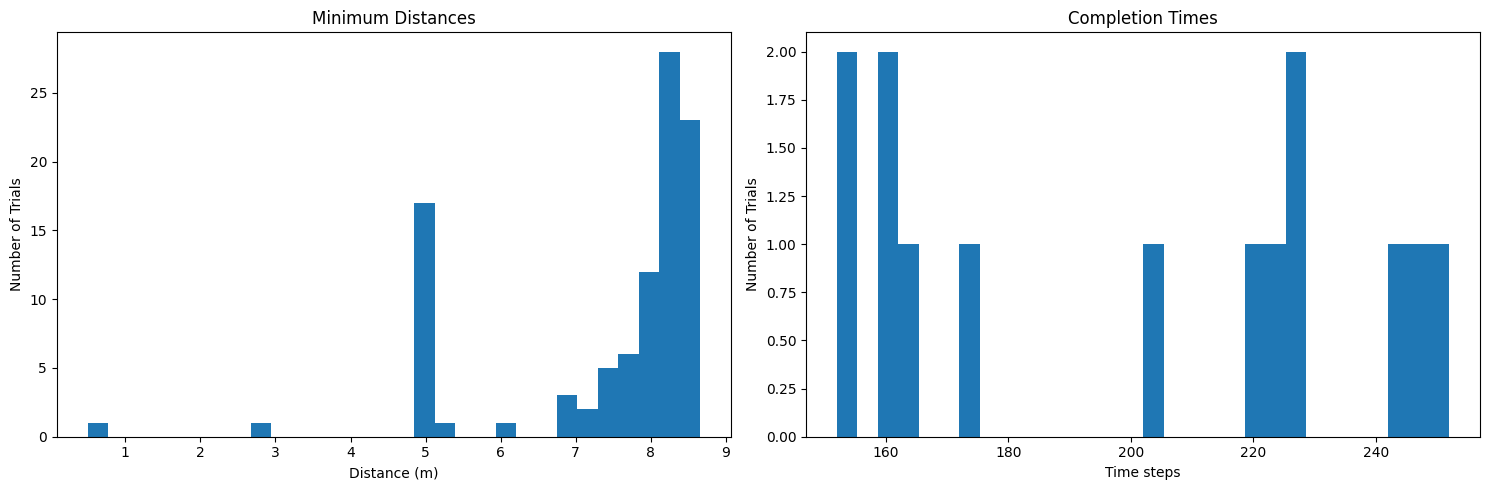

Monte Carlo Simulation Results (100 trials):
Success Rate: 14.00%
Average Minimum Distance: 7.42 m
Std Dev of Minimum Distance: 1.51 m
Average Completion Time (successful trials): 200.64 steps


In [12]:
# Run Monte Carlo analysis with 100 trials
trails = 100
analyze_monte_carlo_results(run_monte_carlo_simulation(trails,Param_SV, Param_EV),trails)